# seiyrdc_sb

In [1]:
import numpy as np
import gillespy2
from gillespy2 import Model, Species, Reaction, Parameter, RateRule, AssignmentRule, FunctionDefinition
from gillespy2 import EventAssignment, EventTrigger, Event


from sciope.utilities.priors.uniform_prior import UniformPrior
from sciope.utilities.summarystats import auto_tsfresh
from sciope.inference.rep_smc_abc import ReplenishmentSMCABC
from sciope.utilities.summarystats.identity import Identity

import matplotlib.pyplot as plt

# To run a simulation using the SSA Solver simply omit the solver argument from model.run().
from gillespy2 import VariableSSACSolver
# from gillespy2 import TauLeapingSolver
# from gillespy2 import TauHybridSolver
# from gillespy2 import ODESolver

In [2]:
class seiyrdc_sb(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="seiyrdc_sb")
        self.volume = 1

        # Parameters
        self.add_parameter(Parameter(name="beta", expression=1))
        self.add_parameter(Parameter(name="kappa", expression=0.3))
        self.add_parameter(Parameter(name="delta", expression=0.005))
        self.add_parameter(Parameter(name="nu", expression=0.2))

        # Species
        self.add_species(Species(name="S", initial_value=124783, mode="discrete"))
        self.add_species(Species(name="E", initial_value=60, mode="discrete"))
        self.add_species(Species(name="I", initial_value=30, mode="discrete"))
        self.add_species(Species(name="Y", initial_value=23, mode="discrete"))
        self.add_species(Species(name="R", initial_value=101, mode="discrete"))
        self.add_species(Species(name="D", initial_value=3, mode="discrete"))
        self.add_species(Species(name="C", initial_value=0, mode="discrete"))

        # Reactions
        self.add_reaction(Reaction(name="exposure", reactants={'S': 1, 'I': 1}, products={'E': 1, 'I': 1}, propensity_function="beta * S * I / 125000"))
        self.add_reaction(Reaction(name="incubation_asymptomatic", reactants={'E': 1}, products={'I': 1}, propensity_function="(1 - nu) * 0.16 * E"))
        self.add_reaction(Reaction(name="incubation_symptomatic", reactants={'E': 1}, products={'Y': 1}, propensity_function="nu * 0.16 * E"))
        self.add_reaction(Reaction(name="recovery", reactants={'Y': 1}, products={'R': 1}, rate=self.listOfParameters["kappa"]))
        self.add_reaction(Reaction(name="death", reactants={'Y': 1}, products={'D': 1}, rate=self.listOfParameters["delta"]))
        self.add_reaction(Reaction(name="clearance", reactants={'I': 1}, products={'C': 1}, rate=self.listOfParameters["kappa"]))

        # Timespan
        self.timespan(np.linspace(0, 85, 86))
model = seiyrdc_sb()
compiled_solver = VariableSSACSolver(model)

## Data

In [3]:
import pandas as pd
import datetime

sb_data = pd.read_csv("../data/SBC_COVID19_Data_083120.csv", header=None)
sb_data = sb_data[sb_data.ne('-').all(1)]
sb_data = sb_data[sb_data.ne('—').all(1)]
context_date = None
rows = []
for _,row in sb_data.iterrows():
    if row.isna().sum() == 3:
        ds = " ".join([row[0],row[1],row[2]])
        d = datetime.datetime.strptime(ds, '%B %d %Y')
        context_date = d.date()
    else:
        if row.isna().sum() == 1:
            # Active cases were not recorded, last column is deaths so shift it over 1
            rows.append((context_date,) + (row[0], row[1], row[2], row[3], -1, row[4]))
        else:
            rows.append((context_date,) + tuple(row))
df = pd.DataFrame(rows, columns = ["Date", "Area", "Daily Cases", "Cumulative Cases", "Recovered", "Active", "Deaths"])

df['Deaths'] = df['Deaths'].astype(np.int)
df['Daily Cases'] = df['Daily Cases'].astype(np.int)
df['Cumulative Cases'] = df['Cumulative Cases'].astype(np.int)
df['Recovered'] = df['Recovered'].astype(np.int)
df['Active'] = df['Active'].astype(np.int)
# Enforce a conservation
df['Active'] = df['Cumulative Cases'] - df['Recovered'] - df['Deaths']

df = df.sort_values(['Date','Area'])


df = df[pd.to_datetime(df['Date']) > datetime.datetime(2020, 6, 1)]
sb_cases = df[df['Area'] == "CITY OF SANTA BARBARA and the unincorporated area of Mission Canyon"]
goleta_cases = df[df['Area'] == "CITY OF GOLETA"]
iv_cases = df[df['Area'] == "COMMUNITY OF ISLA VISTA"]

confirmed = sb_cases['Active'].values + goleta_cases['Active'].values + iv_cases['Active'].values
recovered = sb_cases['Recovered'].values + goleta_cases['Recovered'].values + iv_cases['Recovered'].values
dead = sb_cases['Deaths'].values + goleta_cases['Deaths'].values + iv_cases['Deaths'].values
obs_times = (pd.to_datetime(sb_cases['Date']) - pd.to_datetime(sb_cases['Date'].iloc[0])).dt.days.values # observation times

confirmed_interp = np.interp(np.linspace(0,obs_times[-1],obs_times[-1] + 1), obs_times, confirmed)[5:]
recovered_interp = np.interp(np.linspace(0,obs_times[-1],obs_times[-1] + 1), obs_times, recovered)[5:]
dead_interp = np.interp(np.linspace(0,obs_times[-1],obs_times[-1] + 1), obs_times, dead)[5:]

# obs_data should contain the observed dataset
obs_data = np.vstack([confirmed_interp, recovered_interp, dead_interp]).reshape(1,3,-1)

## Prior Distributions

In [4]:
parameter_names = ['beta', 'kappa', 'delta', 'nu']
lower_bounds =    [0     ,       0,       0,    0]
upper_bounds =    [3     ,       1,     0.1,    1]
prior = UniformPrior(np.array(lower_bounds), np.array(upper_bounds))

## Simulator

In [5]:
# Here we use the GillesPy2 Solver
def simulator(params, model):    
    res = model.run(
            solver = compiled_solver,
            show_labels = True,
            seed = np.random.randint(1e8),
            variables = {parameter_names[i] : params[i] for i in range(len(parameter_names))})
    
    # Extract only observed species
    symptomatic = res['Y']
    recovered = res['R']
    dead = res['D']

    return np.vstack([symptomatic, recovered, dead])[np.newaxis,:,:]

# Wrapper, simulator function to abc should should only take one argument (the parameter point)
def simulator2(x):
    return simulator(x, model=model)

## ABC Inference

In [6]:
normalization_values = np.max(obs_data, axis = 2)[0,:]
def max_normalization(data):
    dc = data[0].reshape(1,3,-1).copy().astype(np.float32)
    dc[0,0,:] = dc[0,0,:]/normalization_values[0]
    dc[0,1,:] = dc[0,1,:]/normalization_values[1]
    dc[0,2,:] = dc[0,2,:]/normalization_values[2]
    return dc

summary_stat = Identity(max_normalization)

In [7]:
# Start abc instance
abc = ReplenishmentSMCABC(obs_data, # Observed Dataset
                          simulator2, # Simulator method
                          prior,
                          summaries_function=summary_stat.compute) # Prior
abc.compute_fixed_mean(1)

In [8]:
import dask
with dask.config.set(scheduler = 'processes', workers = 20):
    smc_abc_results = abc.infer(num_samples = 500)

Tol : 45.65895462036133, R : 9, p_acc : 0.41720000000000007
Tol : 7.3624067306518555, R : 12, p_acc : 0.6564
Tol : 6.94508695602417, R : 15, p_acc : 0.5172000000000001
Tol : 6.705032825469971, R : 17, p_acc : 0.48439999999999994
Tol : 6.405353546142578, R : 20, p_acc : 0.406
Tol : 5.947761535644531, R : 24, p_acc : 0.34674285714285713
Tol : 5.333890438079834, R : 31, p_acc : 0.2843428571428571
Tol : 4.803443908691406, R : 32, p_acc : 0.2777454545454546
Tol : 4.344053745269775, R : 40, p_acc : 0.22493333333333335
Tol : 3.9991960525512695, R : 47, p_acc : 0.18430270270270271
Tol : 3.7054758071899414, R : 50, p_acc : 0.1755
Tol : 3.4138221740722656, R : 52, p_acc : 0.168
Tol : 3.1246042251586914, R : 61, p_acc : 0.13945882352941177
Tol : 2.9237184524536133, R : 71, p_acc : 0.12601311475409838
Tol : 2.727776527404785, R : 86, p_acc : 0.10650526315789473
Tol : 2.523832321166992, R : 127, p_acc : 0.07115555555555556
Tol : 2.3629162311553955, R : 160, p_acc : 0.05941333333333333
Tol : 2.23346

In [9]:
posterior = smc_abc_results['accepted_samples']

## Analysis

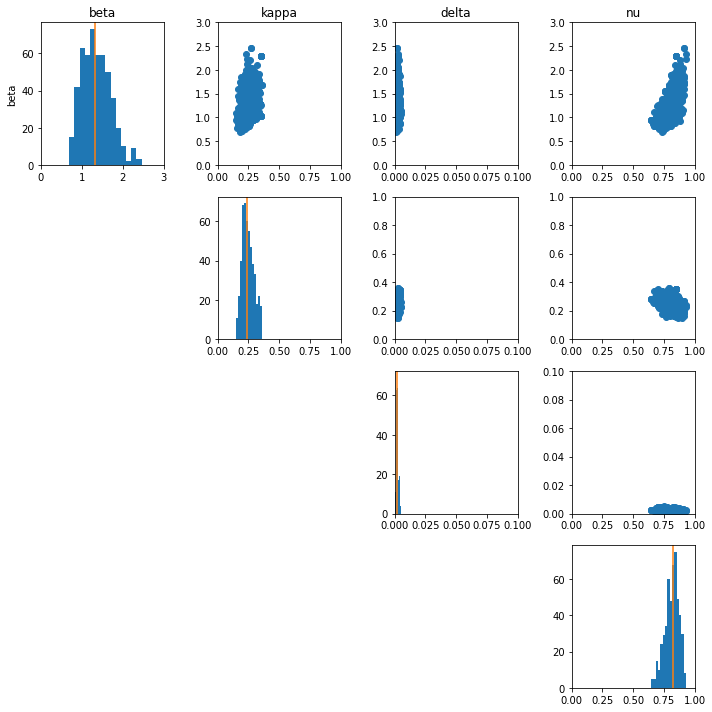

In [10]:
fig, ax = plt.subplots(posterior.shape[1], posterior.shape[1])
for i in range(posterior.shape[1]):
    for j in range(posterior.shape[1]):
        if i > j:
            ax[i,j].axis('off')
        else:
            if i == j:
                ax[i,j].hist(posterior[:,i], bins = 'auto')
                ax[i,j].axvline(np.median(posterior[:,i]), color = 'C1')
                ax[i,j].set_xlim(lower_bounds[i], upper_bounds[i])
            else:
                ax[i,j].scatter(posterior[:,j], posterior[:,i])
                ax[i,j].set_ylim(lower_bounds[i], upper_bounds[i])
                ax[i,j].set_xlim(lower_bounds[j], upper_bounds[j])
    ax[i,0].set_ylabel(parameter_names[i])
    ax[0,i].set_title(parameter_names[i])
fig.set_size_inches(10,10)
fig.tight_layout()

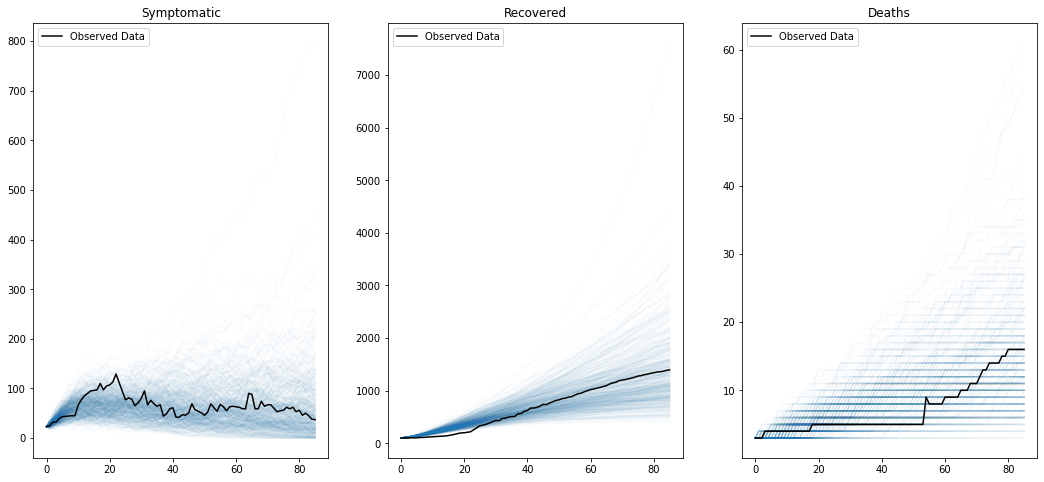

In [11]:
fig, ax = plt.subplots(1,3)
for i in range(posterior.shape[0]):
    res = simulator2(posterior[i,:])
    ax[0].plot(res[0,0,:], color = 'C0', alpha = 0.02)
    ax[1].plot(res[0,1,:], color = 'C0', alpha = 0.02)
    ax[2].plot(res[0,2,:], color = 'C0', alpha = 0.02)
ax[0].plot(obs_data[0,0,:], color = 'black', label = 'Observed Data')
ax[1].plot(obs_data[0,1,:], color = 'black', label = 'Observed Data')
ax[2].plot(obs_data[0,2,:], color = 'black', label = 'Observed Data')
ax[0].set_title("Symptomatic")
ax[1].set_title("Recovered")
ax[2].set_title("Deaths")
ax[0].legend()
ax[1].legend()
ax[2].legend()
fig.set_size_inches(18, 8)